In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdsong-recognition/example_test_audio_metadata.csv
/kaggle/input/birdsong-recognition/sample_submission.csv
/kaggle/input/birdsong-recognition/train.csv
/kaggle/input/birdsong-recognition/test.csv
/kaggle/input/birdsong-recognition/example_test_audio_summary.csv
/kaggle/input/birdsong-recognition/example_test_audio/ORANGE-7-CAP_20190606_093000.pt623.mp3
/kaggle/input/birdsong-recognition/example_test_audio/BLKFR-10-CPL_20190611_093000.pt540.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC153881.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC423355.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC45484.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC109911.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC299486.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC474580.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC299484.mp3
/kaggle/input/birdsong-recognition/train_audio/rudduc/XC165233.mp3


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import IPython.display as ipd


# Data Exploration:

In [3]:
# Import train data
train_csv = pd.read_csv("../input/birdsong-recognition/train.csv")

# Overview of a few lines
train_csv.head(2)

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...   xc_id  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...  134874   
1        36  XC135454.mp3           both  Alder Flycatcher  ...  135454   

                                 url        country            author  \
0  https://www.xeno-canto.org/134874  United States  Jonathon Jongsma   
1  https://www.xeno-canto.org/135454  United States       Mike Nelson   

                        primary_label longitude         length   time  \
0  Empidonax alnorum_Alder Flycatcher   -92.962  Not specified   8:00   
1  Empidonax alnorum_Alder Flycatcher  -82.1106         0-3(s)  08:30   

          recordist                                            license  
0  Jonathon Jongsma        Creative Commons Attribution-ShareAlike 3.0  
1       Mike Nelson  Creative Commons Attribution-NonCommercial-Sha...  

[2 rows x 35 columns]

In [4]:
test_csv = pd.read_csv("../input/birdsong-recognition/test.csv")

# Overview of a few lines
test_csv.head(3)

site                                      row_id  seconds  \
0  site_1   site_1_0a997dff022e3ad9744d4e7bbf923288_5        5   
1  site_1  site_1_0a997dff022e3ad9744d4e7bbf923288_10       10   
2  site_1  site_1_0a997dff022e3ad9744d4e7bbf923288_15       15   

                           audio_id  
0  0a997dff022e3ad9744d4e7bbf923288  
1  0a997dff022e3ad9744d4e7bbf923288  
2  0a997dff022e3ad9744d4e7bbf923288

In [5]:
print("There are {:,} bird species in the train dataset.".format(len(train_csv['species'].unique())))


There are 264 bird species in the train dataset.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


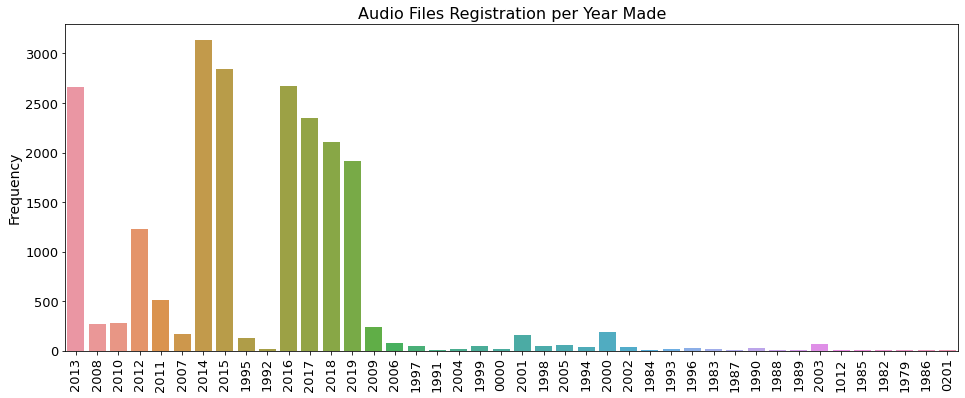

In [6]:
# Create some time features
train_csv['year'] = train_csv['date'].apply(lambda x: x.split('-')[0])
train_csv['month'] = train_csv['date'].apply(lambda x: x.split('-')[1])
train_csv['day_of_month'] = train_csv['date'].apply(lambda x: x.split('-')[2])

plt.figure(figsize=(16, 6))
ax = sns.countplot(train_csv['year'])

plt.title("Audio Files Registration per Year Made", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Months')

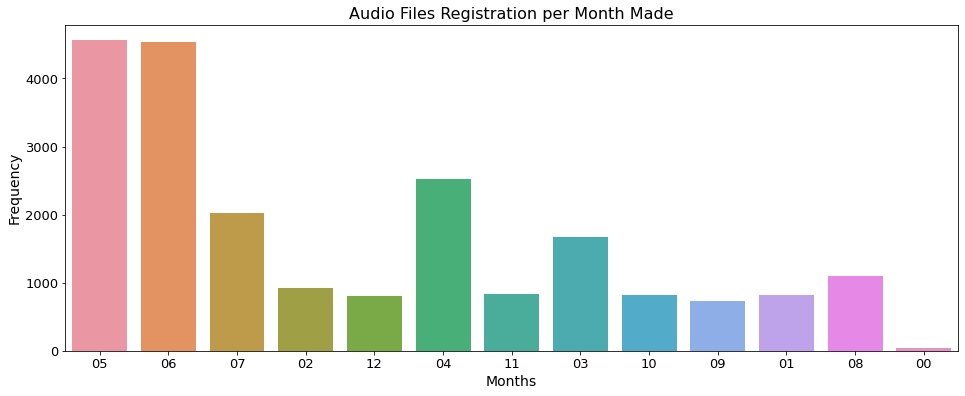

In [7]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_csv['month'])

plt.title("Audio Files Registration per Month Made", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Months", fontsize=14)

**Where were birds recoded**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


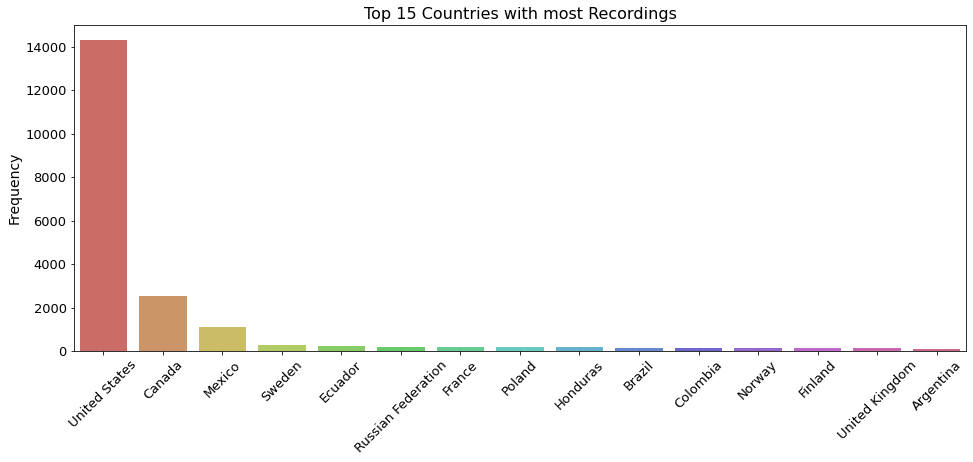

In [8]:
top_15 = list(train_csv['country'].value_counts().head(15).reset_index()['index'])
data = train_csv[train_csv['country'].isin(top_15)]

# === PLOT ===
plt.figure(figsize=(16, 6))
ax = sns.countplot(data['country'], palette='hls', order = data['country'].value_counts().index)

plt.title("Top 15 Countries with most Recordings", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

# Selection Of Some Species:

In [9]:
# Selection of species (to diminish computation time)
train_data = pd.DataFrame()

for row in range(train_csv.shape[0]) :
    for name in ['aldfly','dowwoo', 'hamfly', 'robgro', 'scatan'] :
        if train_csv.iloc[row]['ebird_code'] == name :
            train_data = train_data.append(train_csv.iloc[row])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


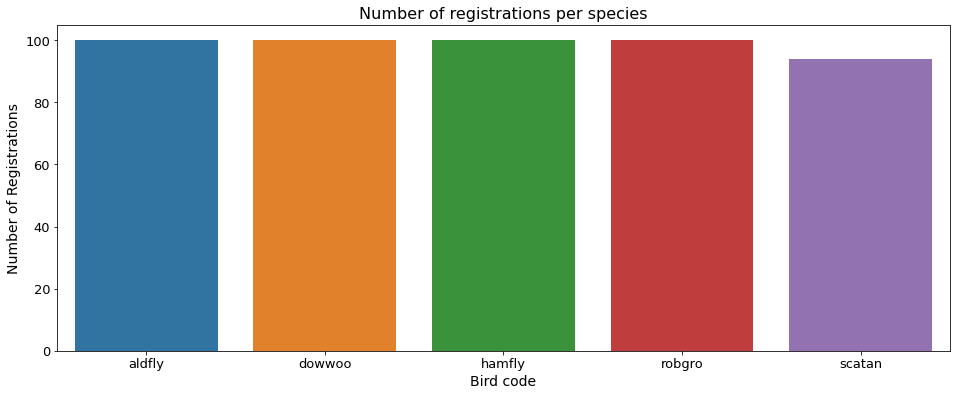

In [10]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_data['ebird_code'])

plt.title("Number of registrations per species", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Number of Registrations", fontsize=14)
plt.xlabel("Bird code", fontsize=14);

# Description Of The Audio Files:

In [11]:
# Create Full Path so we can access data more easily
base_dir = '../input/birdsong-recognition/train_audio/'
train_data['full_path'] = base_dir + train_csv['ebird_code'] + '/' + train_data['filename']

# Now let's sample the audio files for our 5 bird species
bird_sample_list = ["aldfly", "dowwoo", "hamfly", "robgro", "scatan"]

aldfly = train_data[train_data['ebird_code'] == "aldfly"].sample(1, random_state = 33)['full_path'].values[0]
dowwoo = train_data[train_data['ebird_code'] == "dowwoo"].sample(1, random_state = 33)['full_path'].values[0]
hamfly = train_data[train_data['ebird_code'] == "hamfly"].sample(1, random_state = 33)['full_path'].values[0]
robgro = train_data[train_data['ebird_code'] == "robgro"].sample(1, random_state = 33)['full_path'].values[0] 
scatan = train_data[train_data['ebird_code'] == "scatan"].sample(1, random_state = 33)['full_path'].values[0]

In [12]:
# aldfly
ipd.Audio(aldfly)

In [13]:
# dowwoo
ipd.Audio(dowwoo)

In [14]:
# hamfly
ipd.Audio(hamfly)

In [15]:
# robgro
ipd.Audio(robgro)

In [16]:
# scatan
ipd.Audio(scatan)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


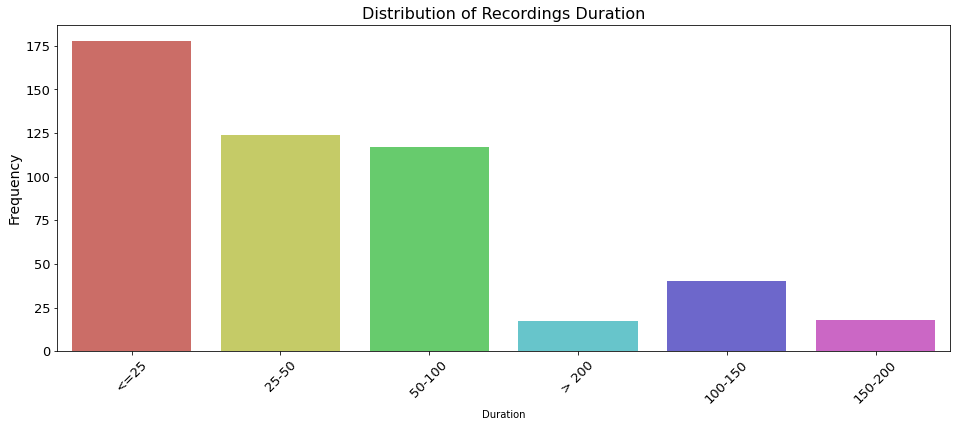

In [17]:
# Creating Interval for *duration* variable
train_data['duration_interval'] = ""
train_data.loc[train_data['duration'] <= 25, 'duration_interval'] = "<=25"
train_data.loc[(train_data['duration'] > 25) & (train_data['duration'] <= 50), 'duration_interval'] = "25-50"
train_data.loc[(train_data['duration'] > 50) & (train_data['duration'] <= 100), 'duration_interval'] = "50-100"
train_data.loc[(train_data['duration'] > 100) & (train_data['duration'] <= 150), 'duration_interval'] = "100-150"
train_data.loc[(train_data['duration'] > 150) & (train_data['duration'] <= 200), 'duration_interval'] = "150-200"
train_data.loc[(train_data['duration'] >= 200), 'duration_interval'] = "> 200"

plt.figure(figsize=(16, 6))
ax = sns.countplot(train_data['duration_interval'], palette="hls")

plt.title("Distribution of Recordings Duration", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("Duration");

# Extracting Features From Sound

In [18]:
# Importing 1 file
y, sr = librosa.load(aldfly)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


y: [ 0.000000e+00  0.000000e+00  0.000000e+00 ... -3.143294e-06  9.721286e-06
  9.611878e-06] 

y shape: (1473408,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 66.82122448979592


In [19]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.000000e+00  0.000000e+00  0.000000e+00 ... -3.143294e-06  9.721286e-06
  9.611878e-06] 

Audio File shape: (1473408,)


In [20]:
# Importing the 5 files
y_aldfly, sr_aldfly = librosa.load(aldfly)
audio_aldfly, _ = librosa.effects.trim(y_aldfly)

y_dowwoo, sr_dowwoo = librosa.load(dowwoo)
audio_dowwoo, _ = librosa.effects.trim(y_dowwoo)

y_hamfly, sr_hamfly = librosa.load(hamfly)
audio_hamfly, _ = librosa.effects.trim(y_hamfly)

y_robgro, sr_robgro = librosa.load(robgro)
audio_robgro, _ = librosa.effects.trim(y_robgro)

y_scatan, sr_scatan = librosa.load(scatan)
audio_scatan, _ = librosa.effects.trim(y_scatan)

/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# Waveform (2D Representation)


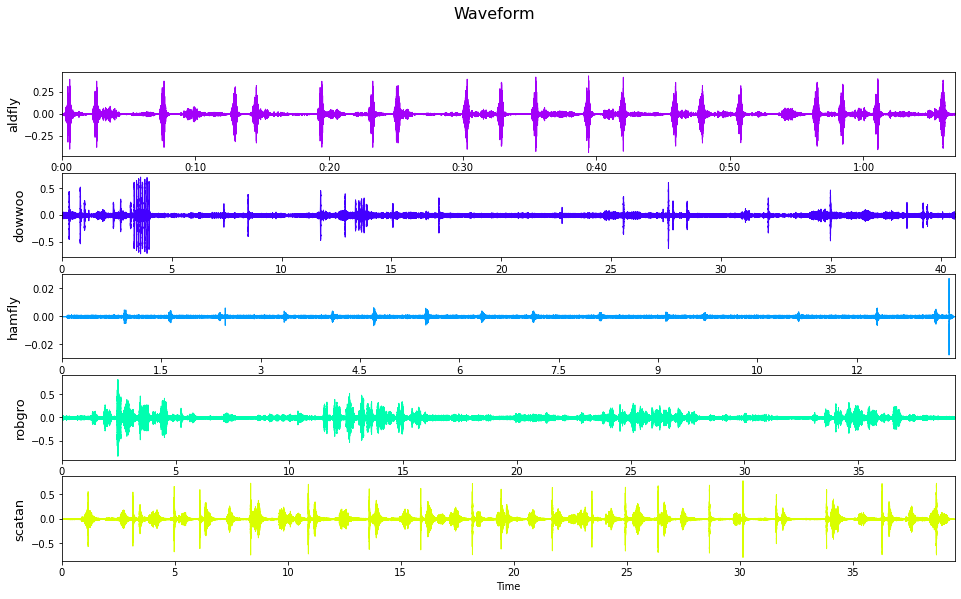

In [21]:
fig, ax = plt.subplots(5, figsize = (16, 9))
fig.suptitle('Waveform', fontsize=16)

librosa.display.waveplot(y = audio_aldfly, sr = sr_aldfly, color = "#A300F9", ax=ax[0])
librosa.display.waveplot(y = audio_dowwoo, sr = sr_dowwoo, color = "#4300FF", ax=ax[1])
librosa.display.waveplot(y = audio_hamfly, sr = sr_hamfly, color = "#009DFF", ax=ax[2])
librosa.display.waveplot(y = audio_robgro, sr = sr_robgro, color = "#00FFB0", ax=ax[3])
librosa.display.waveplot(y = audio_scatan, sr = sr_scatan, color = "#D9FF00", ax=ax[4]);

for i, name in zip(range(5), bird_sample_list):
    ax[i].set_ylabel(name, fontsize=13)

# Fourier Transform


Text(0, 0.5, 'Magnitude')

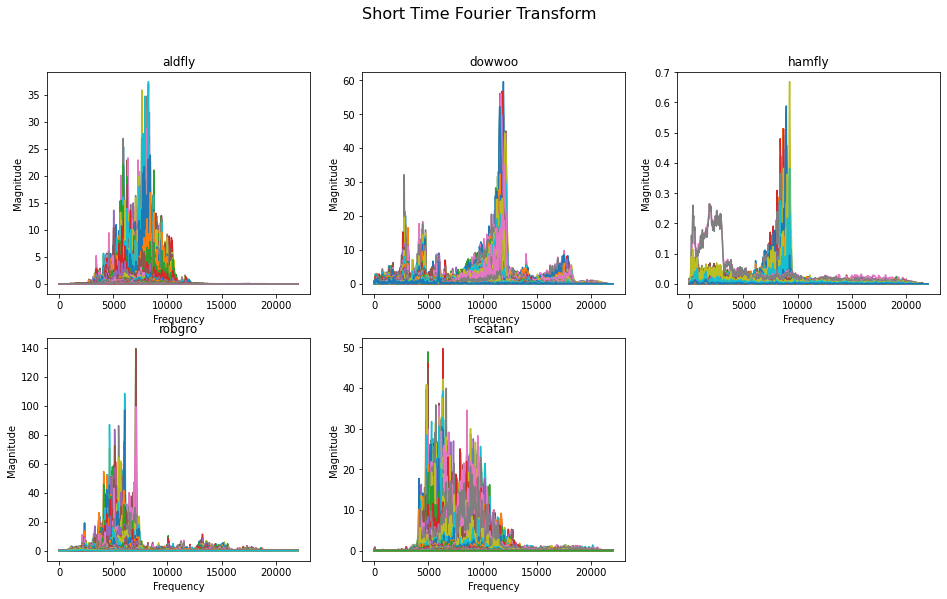

In [22]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Short Time Fourier Transform', fontsize=16)
fig.delaxes(ax[1, 2])

# Short-time Fourier transform (STFT)
Magnitude_aldfly = np.abs(librosa.stft(audio_aldfly, n_fft = n_fft, hop_length = hop_length))
Frequency_aldfly = np.linspace(0,sr_aldfly,len(Magnitude_aldfly))
plt.subplot(231)
plt.plot(Frequency_aldfly,Magnitude_aldfly)
plt.title('aldfly')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_dowwoo = np.abs(librosa.stft(audio_dowwoo, n_fft = n_fft, hop_length = hop_length))
Frequency_dowwoo = np.linspace(0,sr_dowwoo,len(Magnitude_dowwoo))
plt.subplot(232)
plt.plot(Frequency_dowwoo,Magnitude_dowwoo)
plt.title('dowwoo')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_hamfly = np.abs(librosa.stft(audio_hamfly, n_fft = n_fft, hop_length = hop_length))
Frequency_hamfly = np.linspace(0,sr_hamfly,len(Magnitude_hamfly))
plt.subplot(233)
plt.plot(Frequency_hamfly,Magnitude_hamfly)
plt.title('hamfly')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_robgro = np.abs(librosa.stft(audio_robgro, n_fft = n_fft, hop_length = hop_length))
Frequency_robgro = np.linspace(0,sr_robgro,len(Magnitude_robgro))
plt.subplot(234)
plt.plot(Frequency_robgro,Magnitude_robgro)
plt.title('robgro')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_scatan = np.abs(librosa.stft(audio_scatan, n_fft = n_fft, hop_length = hop_length))
Frequency_scatan = np.linspace(0,sr_scatan,len(Magnitude_scatan))
plt.subplot(235)
plt.plot(Frequency_scatan,Magnitude_scatan)
plt.title('scatan')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

# Spectrogram

/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/conda/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


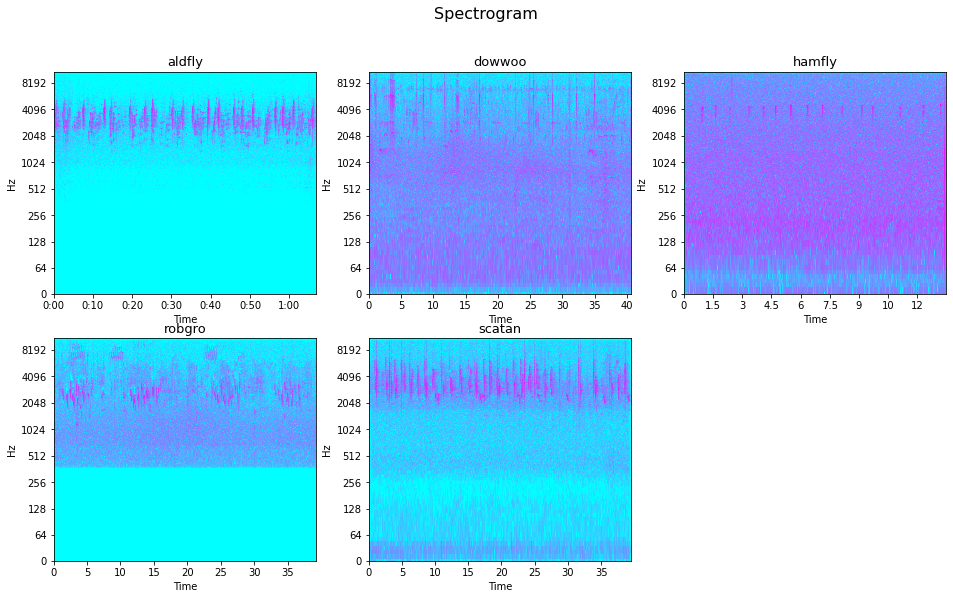

In [23]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_aldfly = librosa.amplitude_to_db(Magnitude_aldfly, ref = np.max)
DB_dowwoo = librosa.amplitude_to_db(Magnitude_dowwoo, ref = np.max)
DB_hamfly = librosa.amplitude_to_db(Magnitude_hamfly, ref = np.max)
DB_robgro = librosa.amplitude_to_db(Magnitude_robgro, ref = np.max)
DB_scatan = librosa.amplitude_to_db(Magnitude_scatan, ref = np.max)

# === PLOT ===
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(DB_aldfly, sr = sr_aldfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 0])
librosa.display.specshow(DB_dowwoo, sr = sr_dowwoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 1])
librosa.display.specshow(DB_hamfly, sr = sr_hamfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 2])
librosa.display.specshow(DB_robgro, sr = sr_robgro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[1, 0])
librosa.display.specshow(DB_scatan, sr = sr_scatan, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[1, 1]);

for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13) 

# Mel Spectrogram


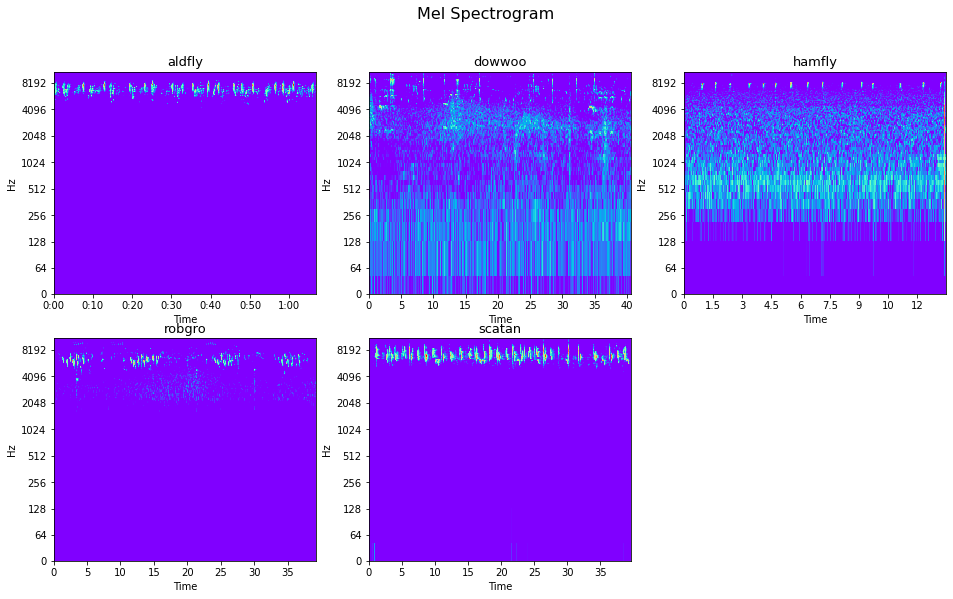

In [24]:
# Create the Mel Spectrograms
S_aldfly = librosa.feature.melspectrogram(y_aldfly, sr=sr_aldfly)
S_DB_aldfly = librosa.amplitude_to_db(S_aldfly, ref=np.max)

S_dowwoo = librosa.feature.melspectrogram(y_dowwoo, sr=sr_dowwoo)
S_DB_dowwoo = librosa.amplitude_to_db(S_dowwoo, ref=np.max)

S_hamfly = librosa.feature.melspectrogram(y_hamfly, sr=sr_hamfly)
S_DB_hamfly = librosa.amplitude_to_db(S_hamfly, ref=np.max)

S_robgro = librosa.feature.melspectrogram(y_robgro, sr=sr_robgro)
S_DB_robgro = librosa.amplitude_to_db(S_robgro, ref=np.max)

S_scatan = librosa.feature.melspectrogram(y_scatan, sr=sr_scatan)
S_DB_scatan = librosa.amplitude_to_db(S_scatan, ref=np.max)

# === PLOT ====
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Mel Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(S_DB_aldfly, sr = sr_aldfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 0])
librosa.display.specshow(S_DB_dowwoo, sr = sr_dowwoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 1])
librosa.display.specshow(S_DB_hamfly, sr = sr_hamfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(S_DB_robgro, sr = sr_robgro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[1, 0])
librosa.display.specshow(S_DB_scatan, sr = sr_scatan, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[1, 1])

for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)


# Mel Frequency Cepstral Coefficients (MFCCs)


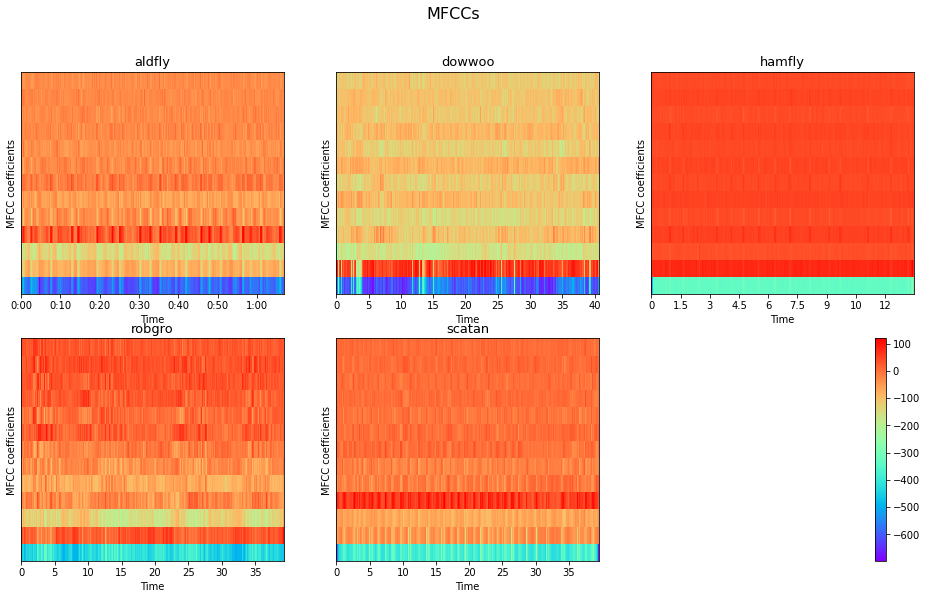

In [25]:
MFCCs_aldfly = librosa.feature.mfcc(audio_aldfly, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_dowwoo = librosa.feature.mfcc(audio_dowwoo, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_hamfly = librosa.feature.mfcc(audio_hamfly, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_robgro = librosa.feature.mfcc(audio_robgro, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_scatan = librosa.feature.mfcc(audio_scatan, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)

#### PLOT ### 

fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('MFCCs', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(MFCCs_aldfly, sr=sr_aldfly, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 0])
librosa.display.specshow(MFCCs_dowwoo, sr=sr_dowwoo, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 1])
librosa.display.specshow(MFCCs_hamfly, sr=sr_hamfly, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(MFCCs_robgro, sr=sr_robgro, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 0])
librosa.display.specshow(MFCCs_scatan, sr=sr_scatan, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 1])

fig.colorbar(mappable=librosa.display.specshow(MFCCs_scatan, sr=sr_scatan, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 1]), cax=None, ax=ax[1,2])

for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)
    ax[x, y].set_xlabel('Time')
    ax[x, y].set_ylabel('MFCC coefficients')

# Deep learning


In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras as keras
import time

In [27]:
DATA_PATH_STFT = "../input/jsoninputs/Birdcall_inputs/STFT.json"
DATA_PATH_MFCC = "../input/jsoninputs/Birdcall_inputs/MFCC.json"

# Set seed
np.random.seed(42)

# Data functions


In [28]:
def load_data(data_path,data_type):
    """Loads dataset from json file.

        :param data_path (str): Path to json file containing data
        :param data_type (str): Choose between mfcc and stft
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data[data_type])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")
    
    # Reseting indexes
    values = list(set(y))
    
    for i in range(len(values)):
        y[y == values[i]] = i
        

    return  X, y
   

def prepare_datasets(dataset, test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param dataset (str): Value in ["MFCC", "STFT"] selects the dataset to use
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    
    if (dataset == "MFCC"):
        # load data
        X, y = load_data(DATA_PATH_MFCC,"mfcc")
    
    if (dataset == "STFT"):
        # load data
        X, y = load_data(DATA_PATH_STFT,"stft")    

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def add_axis(X_train, X_validation, X_test):
    """ Add an axis to input sets 
    
    :param X_train (ndarray): Input training set
    :param X_validation (ndarray): Input validation set
    :param X_test (ndarray): Input test set
    
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    """
    
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test

# Dense model function


In [29]:
def build_model_dense(input_shape, output_shape):
    """Generates ANN dense model

    :param input_shape (tuple): Shape of input set
    :param output_shape (int): Shape of output layer (i.e. number of labels)
    :return model: ANN dense model
    """

    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=input_shape),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.1),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.01),
        
        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.01),
        
        # output layer
        keras.layers.Dense(output_shape, activation='softmax') #because we have 10 labels
        # softmax picks the max neuron output 
    ])

    return model

# Recurrent Neural Network - Long Short Term Memory function (RNN-LSTM)


In [30]:
def build_model_RNN_LSTM(input_shape, output_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    print(input_shape)
    # 2 LSTM layers
    model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128, dropout = 0.5))
    
    
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return model

# Convolutional model function


In [31]:
def build_model_conv(input_shape, output_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :param output_shape (int): Shape of output layer (i.e. number of labels)
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (4, 4), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return model


# Plotting functions


In [32]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
    

def plot_confusion(model, X, y, labels):
    """Plots a confusion matrix of : model predictions from X_test VS actual targets

        :param model: Trained classifier
        :param X: Input data
        :param y: Target data
        :param labels: Bird labels for confusion plot
        :return:
    """
    
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    
    cm = confusion_matrix(y, predicted_index, normalize='true')


    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=True,
                 cmap='cividis')

    axes = plt.gca()
    axes.xaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center')
    axes.yaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center', rotation = 90)
    plt.show()

# Main program


# *Create datasets*

In [33]:
# Get train, validation and test splits
print("Creating datasets...")
# Data from MFCC will be our reference
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets("MFCC", 0.25, 0.2)

# Data from STFT to compare
X2_train, X2_validation, X2_test, y2_train, y2_validation, y2_test = prepare_datasets("STFT", 0.25, 0.2)

print("Datasets created !")

Creating datasets...
Data succesfully loaded!
Data succesfully loaded!
Datasets created !


# Neural networks modeling


In [34]:
# Create labels vector for birds
bird_labels = ["aldfly", "dowwoo","hamfly","robgro","scatan"]

# Store shape of output data (i.e. nb of labels)
output_shape = len(bird_labels)

# *Dense models*

In [35]:
### DENSE MODEL ###
print("\tDENSE MODEL WITH 1,800,000 PARAMETERS\n")

time_start = time.process_time()

    # Store shape of the input data (2-uple)
input_shape = (X_train.shape[1], X_train.shape[2])

    # Create network
print("Creating network...")
model_dense = build_model_dense(input_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_dense.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nDense model summary :")
model_dense.summary()

    # train model
print("\nTraining model...")
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=200)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_dense, test_acc_dense = model_dense.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc_dense)

    # Calculate computational time
time_dense = (time.process_time() - time_start)
print("\nComputational time of dense NN with 1,800,000 parameters :", time_dense, "seconds")

	DENSE MODEL WITH 1,800,000 PARAMETERS

Creating network...
Network created !

Compiling Network...
Network compiled !

Dense model summary :
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3367)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1724416   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)       

# Recurrent Neural Network - Long Short Term Memory (RNN-LSTM)



In [36]:
### RNN-LSTM (MFCCs) ###
print("\n\n\tRNN-LSTM MODEL (MFCCs)\n")

time_start = time.process_time()

    # Store shape of the input data (2-tuple)
input_shape = (X_train.shape[1], X_train.shape[2])

    # create network
print("Creating network...")
model_RNN_LSTM = build_model_RNN_LSTM(input_shape, output_shape)
model_RNN_LSTM._estimator_type = "classifier"

print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_RNN_LSTM.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\RNN-LSTM model summary :")
model_RNN_LSTM.summary()

    # train model
print("\nTraining model...")
history_RNN_LSTM = model_RNN_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=60)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_RNN_LSTM, test_acc_RNN_LSTM = model_RNN_LSTM.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc_RNN_LSTM)

    # Calculate computational time
time_RNN_LSTM = (time.process_time() - time_start)
print("\nComputational time of RNN_LSTM :", time_RNN_LSTM, "seconds")



	RNN-LSTM MODEL (MFCCs)

Creating network...
(259, 13)
Network created !

Compiling Network...
Network compiled !
\RNN-LSTM model summary :
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 259, 256)          276480    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 325       
Total params: 482,181
Trainable params: 482,181
Non-trainable params: 0
______________________________________

# Convolutional model



In [37]:
### Add new axis to inputs for CNN ###
X_train_new, X_validation_new, X_test_new = add_axis(X_train, X_validation, X_test)
X2_train_new, X2_validation_new, X2_test_new = add_axis(X2_train, X2_validation, X2_test)

In [38]:

### CONVOLUTIONAL MODEL (MFCCs) ###
print("\n\n\tCONVOLUTIONAL MODEL (MFCCs)\n")

time_start = time.process_time()

    # Store shape of the input data (3-tuple)
input_shape = (X_train_new.shape[1], X_train_new.shape[2], 1)

    # create network
print("Creating network...")
model_conv = build_model_conv(input_shape, output_shape)
model_conv._estimator_type = "classifier"

print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_conv.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nConvolutional model summary :")
model_conv.summary()

    # train model
print("\nTraining model...")
history_conv = model_conv.fit(X_train_new, y_train, validation_data=(X_validation_new, y_validation), batch_size=32, epochs=150)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_conv, test_acc_conv = model_conv.evaluate(X_test_new, y_test, verbose=2)
print('Test accuracy :', test_acc_conv)

    # Calculate computational time
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")




	CONVOLUTIONAL MODEL (MFCCs)

Creating network...
Network created !

Compiling Network...
Network compiled !

Convolutional model summary :
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 10, 64)       1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 5, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 5, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 3, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 2, 3

In [39]:
### CONVOLUTIONAL MODEL (STFTs) ###
print("\n\n\tCONVOLUTIONAL MODEL (STFTs)\n")

time_start = time.process_time()

    # Store shape of the input data (3-tuple)
input2_shape = (X2_train_new.shape[1], X2_train_new.shape[2], 1)

    # create network
print("Creating network...")
model_conv2 = build_model_conv(input2_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_conv2.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nConvolutional model summary :")
model_conv2.summary()

    # train model
print("\nTraining model...")
history_conv2 = model_conv2.fit(X2_train_new, y2_train, validation_data=(X2_validation_new, y2_validation), batch_size=128, epochs=30)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_conv2, test_acc_conv2 = model_conv2.evaluate(X2_test_new, y2_test, verbose=2)
print('Test accuracy :', test_acc_conv2)

    # Calculate computational time
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")



	CONVOLUTIONAL MODEL (STFTs)

Creating network...
Network created !

Compiling Network...
Network compiled !

Convolutional model summary :
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 254, 64)       1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 127, 64)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 127, 64)       256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 125, 32)       18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 63, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 63, 

# Representation
Show history for loss/accuracy on all epochs for our model.

Show a confusion matrix of : model predictions from X_test VS actual targets.
# Dense model



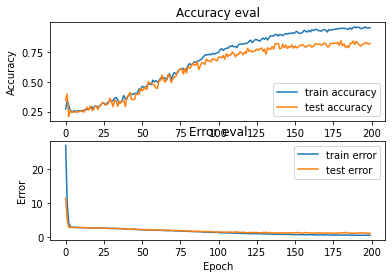

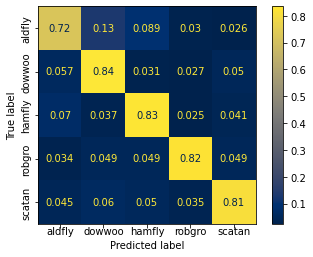

In [40]:
### DENSE MODELS ###

    # Plot accuracy/error for training and validation
plot_history(history_dense)

    # Plot confusion matrix for test data
plot_confusion(model_dense, X_test, y_test, bird_labels)

# Convolutional model
 

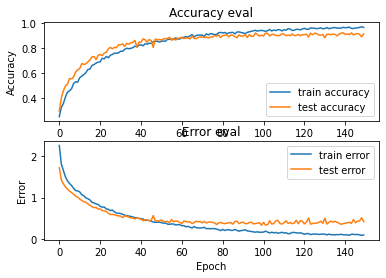

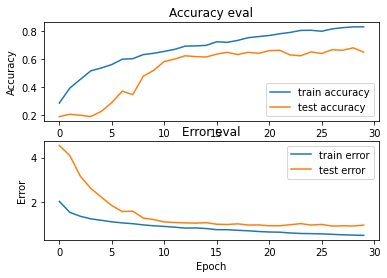

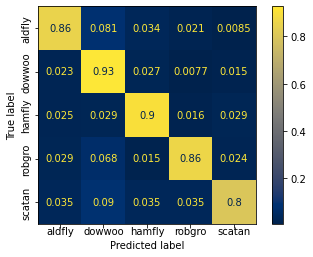

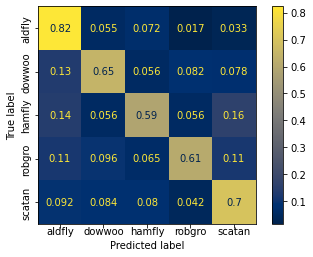

In [41]:
### CONVOLUTIONAL MODEL ###

    # Plot accuracy/error for training and validation
plot_history(history_conv)
plot_history(history_conv2)

    # Plot confusion matrix for test data
plot_confusion(model_conv, X_test_new, y_test, bird_labels)
plot_confusion(model_conv2, X2_test_new, y2_test, bird_labels)

# Model comparison


# Test accuracy
The dense NN has an accuracy on the test set from 75% to 80% whereas the CNN is accurate to 85/88% and RNN-LSTM to 90%.
*CNN and RNN-LSTM are more accurate than the dense NN*


# Ensemble: Simple Averaging Method: RNN-LSTM + CNN

In [47]:
predictionList = [test_acc_conv, test_acc_RNN_LSTM]

In [50]:
weightList = [0.8, 0.1]

In [51]:


def SimpleAverageEnsemble(predictionList):
   
    for pred in predictionList:
        ensemble_preds += pred
    
    ensemble_preds /= len(predictionList)
    
    return ensemble_preds



In [52]:

simple_ensemble_preds = SimpleAverageEnsemble(predictionList)


UnboundLocalError: local variable 'ensemble_preds' referenced before assignment

In [53]:
print("The combined prediction is:",simple_ensemble_preds)

NameError: name 'simple_ensemble_preds' is not defined